In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_excel(r"C:\Users\LENOVO THINKPAD 13\Downloads\Clustering\EastWestAirlines.xlsx", sheet_name="data")

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # can also use median for robustness
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Remove outliers using Z-score method
from scipy.stats import zscore
df_clean = df_imputed[(np.abs(zscore(df_imputed)) < 3).all(axis=1)]

# Feature scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)


                ID#       Balance    Qual_miles     cc1_miles  cc2_miles  \
count  3.630000e+03  3.630000e+03  3.630000e+03  3.630000e+03     3630.0   
mean  -6.263738e-17  3.131869e-17  3.914836e-18 -7.829672e-17        0.0   
std    1.000138e+00  1.000138e+00  1.000138e+00  1.000138e+00        0.0   
min   -1.766325e+00 -9.781017e-01 -1.588691e-01 -7.556644e-01        0.0   
25%   -8.553271e-01 -6.955774e-01 -1.588691e-01 -7.556644e-01        0.0   
50%    9.829343e-03 -3.442363e-01 -1.588691e-01 -7.556644e-01        0.0   
75%    8.637416e-01  3.491287e-01 -1.588691e-01  7.598393e-01        0.0   
max    1.710734e+00  5.016969e+00  9.690039e+00  2.275343e+00        0.0   

       cc3_miles   Bonus_miles   Bonus_trans  Flight_miles_12mo  \
count     3630.0  3.630000e+03  3.630000e+03       3.630000e+03   
mean         0.0 -4.697803e-17  7.829672e-17       5.089287e-17   
std          0.0  1.000138e+00  1.000138e+00       1.000138e+00   
min          0.0 -7.886258e-01 -1.268350e+00   

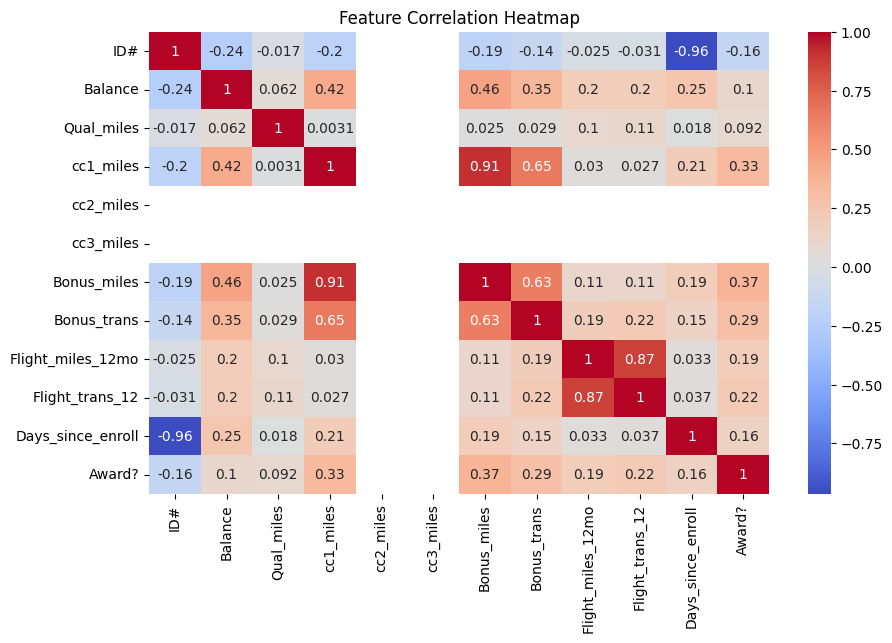

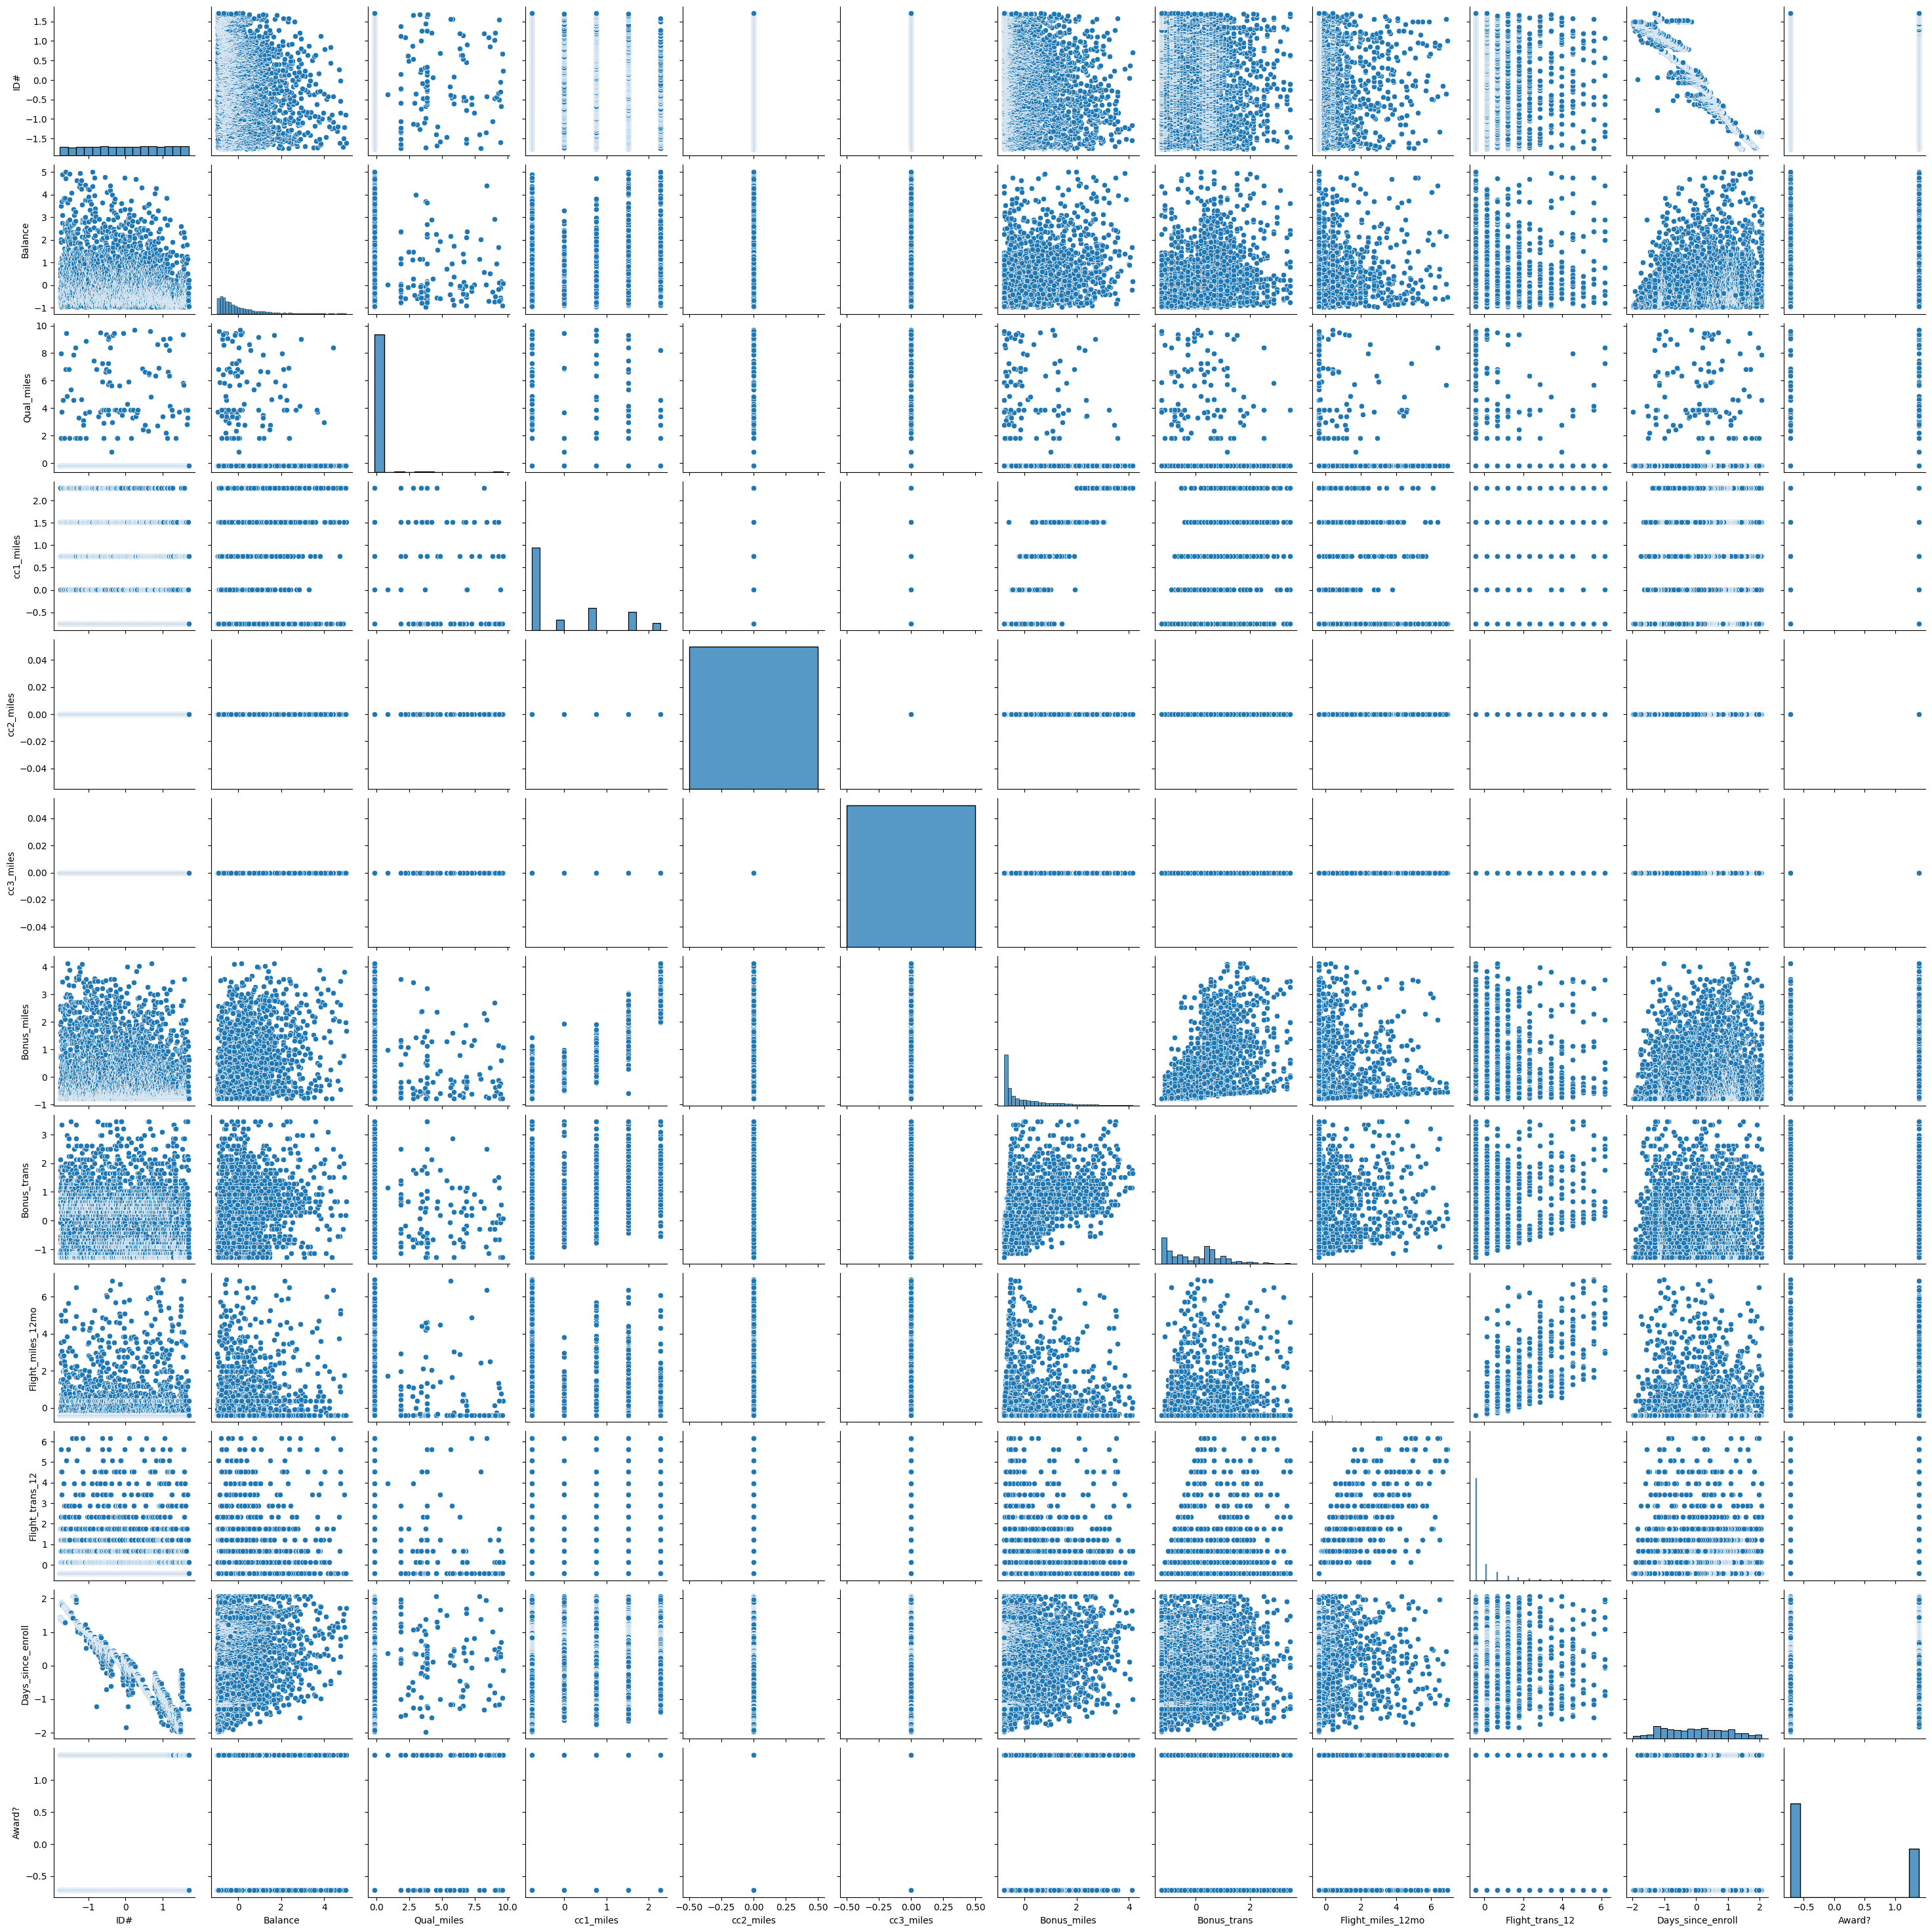

In [2]:
# Basic statistics
print(df_scaled.describe())

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df_scaled)
plt.show()


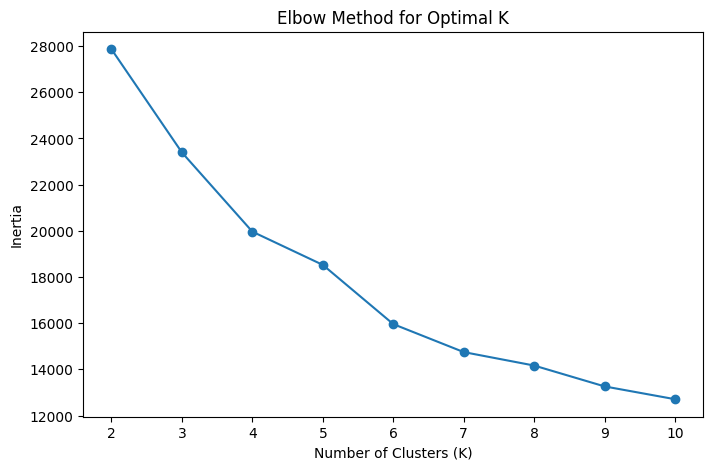

K-Means Silhouette Score: 0.29192710837860614


In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Elbow Method to determine optimal K
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Apply K-Means with chosen K
optimal_k = 3  # Example: choose K where elbow occurs
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_scaled)

# Silhouette Score
print("K-Means Silhouette Score:", silhouette_score(df_scaled, kmeans_labels))


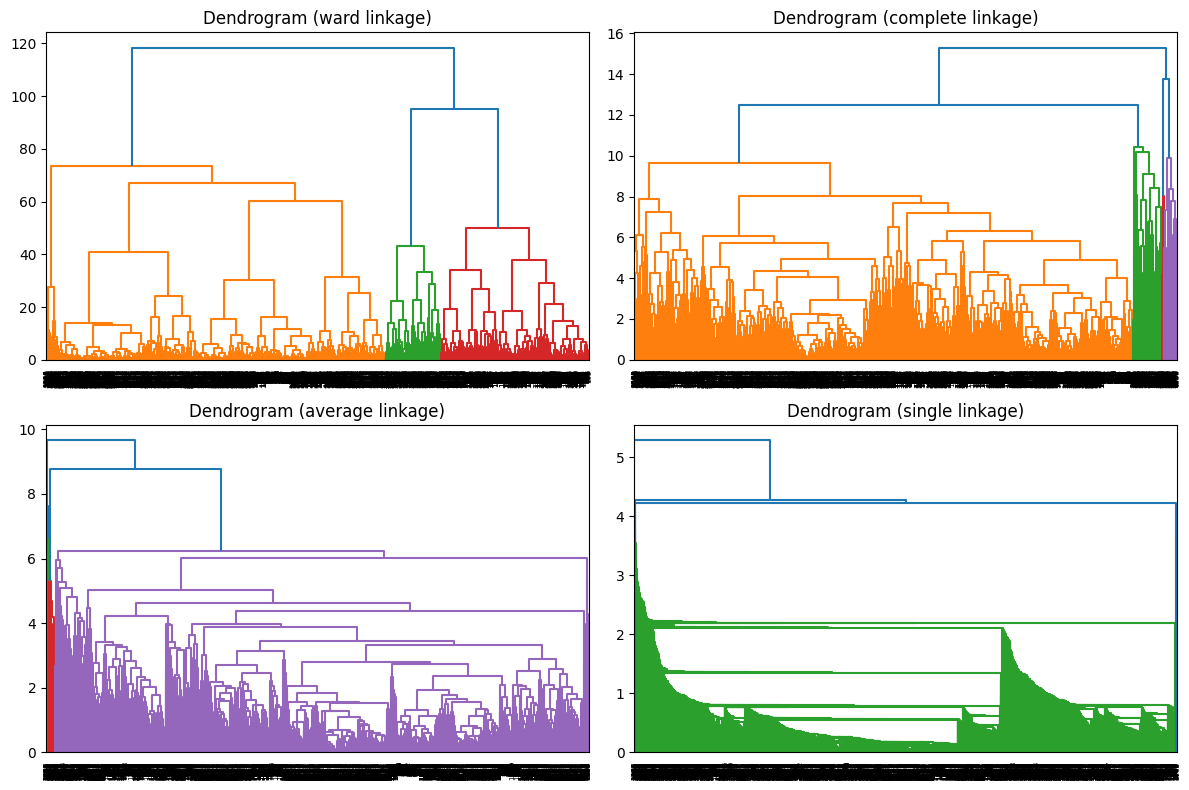

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Generate dendrogram for different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']

plt.figure(figsize=(12,8))
for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i+1)
    Z = linkage(df_scaled, method=method)
    dendrogram(Z)
    plt.title(f"Dendrogram ({method} linkage)")
plt.tight_layout()
plt.show()

# Choose method and cut dendrogram to form clusters
Z = linkage(df_scaled, method='ward')
hier_labels = fcluster(Z, t=3, criterion='maxclust')  # t = number of clusters


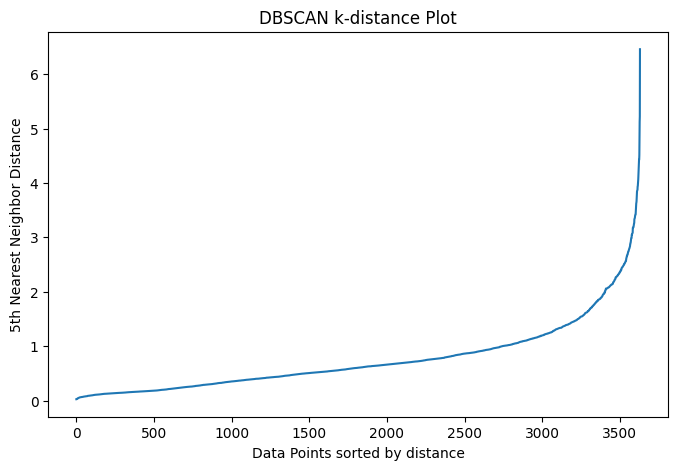

DBSCAN Silhouette Score: -0.27974481353425573


In [5]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Determine optimal eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("DBSCAN k-distance Plot")
plt.show()

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # adjust eps based on k-distance plot
dbscan_labels = dbscan.fit_predict(df_scaled)

# Silhouette Score (excluding noise points)
mask = dbscan_labels != -1
print("DBSCAN Silhouette Score:", silhouette_score(df_scaled[mask], dbscan_labels[mask]))


In [6]:
# K-Means cluster centers
print("K-Means Cluster Centers:\n", kmeans.cluster_centers_)

# Count points in each DBSCAN cluster
unique, counts = np.unique(dbscan_labels, return_counts=True)
print("DBSCAN Cluster Distribution:", dict(zip(unique, counts)))

# Add cluster labels to dataframe for analysis
df_scaled['KMeans_Cluster'] = kmeans_labels
df_scaled['Hier_Cluster'] = hier_labels
df_scaled['DBSCAN_Cluster'] = dbscan_labels


K-Means Cluster Centers:
 [[ 0.25012043 -0.38805893 -0.0494218  -0.6157239   0.          0.
  -0.57021606 -0.52202992 -0.25054321 -0.24244149 -0.2597152  -0.32348529]
 [-0.10094676  0.59233514  0.48140568  0.0141632   0.          0.
   0.26398245  0.66181347  3.03205664  2.97306422  0.12716842  0.60212699]
 [-0.44112687  0.5921898  -0.01049816  1.1355207   0.          0.
   0.99850273  0.82520778 -0.17841902 -0.18091479  0.45331885  0.47071617]]
DBSCAN Cluster Distribution: {np.int64(-1): np.int64(1886), np.int64(0): np.int64(1177), np.int64(1): np.int64(5), np.int64(2): np.int64(121), np.int64(3): np.int64(6), np.int64(4): np.int64(6), np.int64(5): np.int64(79), np.int64(6): np.int64(152), np.int64(7): np.int64(15), np.int64(8): np.int64(11), np.int64(9): np.int64(8), np.int64(10): np.int64(6), np.int64(11): np.int64(9), np.int64(12): np.int64(5), np.int64(13): np.int64(6), np.int64(14): np.int64(42), np.int64(15): np.int64(5), np.int64(16): np.int64(24), np.int64(17): np.int64(6), np

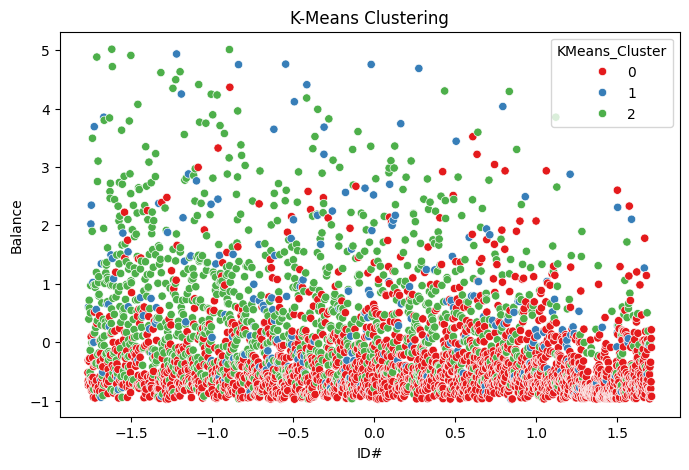

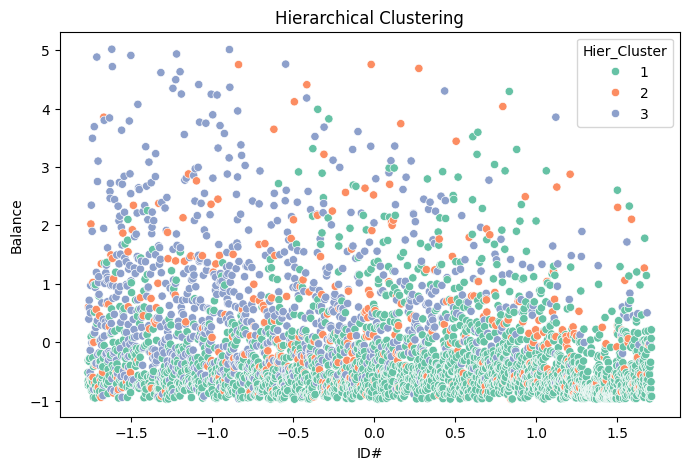

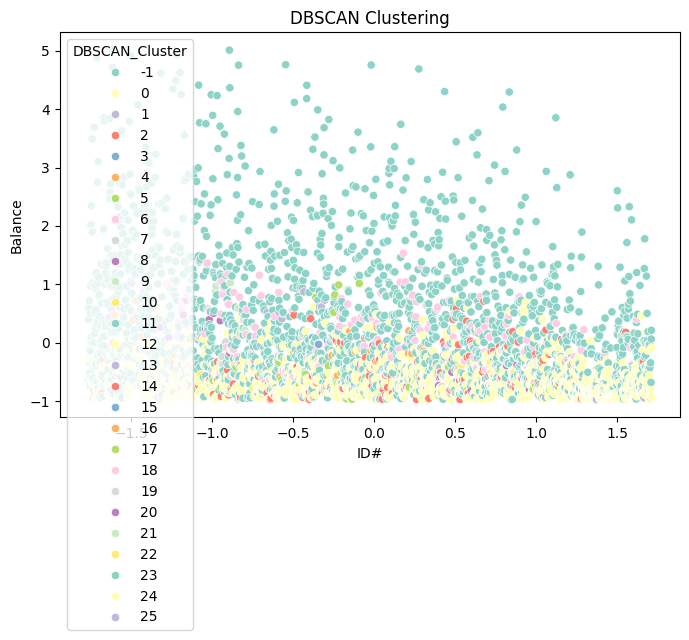

In [7]:
# K-Means scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_scaled.iloc[:,0], y=df_scaled.iloc[:,1], hue='KMeans_Cluster', data=df_scaled, palette='Set1')
plt.title("K-Means Clustering")
plt.show()

# Hierarchical scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_scaled.iloc[:,0], y=df_scaled.iloc[:,1], hue='Hier_Cluster', data=df_scaled, palette='Set2')
plt.title("Hierarchical Clustering")
plt.show()

# DBSCAN scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_scaled.iloc[:,0], y=df_scaled.iloc[:,1], hue='DBSCAN_Cluster', data=df_scaled, palette='Set3')
plt.title("DBSCAN Clustering")
plt.show()


6. Evaluation and Performance Metrics

K-Means & DBSCAN: Silhouette Score to measure cohesion and separation.

Hierarchical Clustering: Compare results using different linkage methods; Ward typically minimizes variance.

DBSCAN: k-distance plot helps tune eps for optimal cluster formation.

Summary of Improvements Made:

Handled missing values and outliers.

Scaled features before clustering.

Added EDA and multiple visualizations.

Used Elbow method for K-Means, dendrogram for hierarchical, and k-distance plot for DBSCAN.

Evaluated clusters using silhouette scores.

Included interpretation of clusters and visualizations.